In [2]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx


from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.optimization.ising import max_cut, tsp, common
from qiskit.aqua.algorithms import VQE, ExactEigensolver, QAOA
from qiskit.aqua.components.optimizers import SPSA, ADAM
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.qasm import pi

from qiskit.optimization.ising import max_cut

from docplex.mp.model import Model
from qiskit.optimization.ising import docplex

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log
from qiskit import IBMQ
provider = IBMQ.load_account()

### Max Cut

In [320]:
w = np.zeros([6,6])
for i in range(5):
    w[i, i+1] = 1
    w[i+1, i] = 1
w[0,5] = 1
w[5,0] = 1
w #ajacency matrix

array([[0., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1., 0.]])

In [321]:
qubitOp, offset = max_cut.get_operator(w)# get the qubit operator given the graph
qubitOp.print_details()

'IIIIZZ\t(0.5+0j)\nIIIZZI\t(0.5+0j)\nIIZZII\t(0.5+0j)\nIZZIII\t(0.5+0j)\nZIIIIZ\t(0.5+0j)\nZZIIII\t(0.5+0j)\n'

#### QAOA

In [14]:
adam = ADAM(maxiter=1000)#optimizer
qaoa = QAOA(qubitOp, adam)#QAOA solver

backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
result = qaoa.run(quantum_instance)
print('solution:', common.sample_most_likely(result['eigvecs'][0]))

#### From Scratch

In [3]:
class circuits:
    def __init__(self, qbits, cbits):
        self.qbits = qbits
        self.cbits = cbits
        self.circ = QuantumCircuit(qbits, cbits)
        for i in range(qbits):
            self.circ.h(i)
    
    def beta_gate(self, beta, qbit):
        self.circ.u3(2*beta, -pi/2, pi/2, qbit)
        
    def gamma_gate(self, gamma, qbit0, qbit1):
        self.circ.cnot(qbit0,qbit1)
        self.circ.u1(-gamma,qbit1)
        self.circ.cnot(qbit0,qbit1)
        
    def measure(self):
        for i in range(self.qbits):
            self.circ.measure(i,i)

In [4]:
class maxcut:
    def __init__(self, G):
        self.G = G
        self.n = len(G)
        self.A = nx.adjacency_matrix(G)
        self.A = np.array(self.A.todense())


    def draw(self):
        colors = ['w' for node in self.G.nodes()]
        pos = nx.spring_layout(self.G)
        default_axes = plt.axes(frameon=True)
        nx.draw_networkx(self.G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
        plt.show()
        
    def build_circuit(self, beta, gamma):
        depth = len(beta)
        self.circuit = circuits(self.n, self.n)
        for i in range(depth):
            for node in range(self.n):
                self.circuit.beta_gate(beta[i],node)
            for (node0, node1) in self.G.edges:
                self.circuit.gamma_gate(gamma[i], node0, node1)
        self.circuit.measure()
        
    def solve(self, sims, print_counts = False):
        backend_sim = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit.circ, backend_sim, shots=sims)

        # Grab the results from the job.
        self.result_sim = job_sim.result()
        self.counts = self.result_sim.get_counts(self.circuit.circ)
        if print_counts:
            print('The count of each state:', self.counts)
        #return self.counts
        
    def get_value(self, state):
        state = state[::-1]
        return max_cut.max_cut_value(np.array(list(state), dtype= np.int), nx.adjacency_matrix(self.G).toarray())
    
    
    
    
    
    
    
    
#     def expect_value(self, beta, gamma, sims):
#         #given beta and gamma, build a new circuit and solve it
#         if beta is None:
#             pass
#         else:
#             self.build_circuit(beta, gamma)
#             self.solve(sims)
#         newcounts = sorted(self.counts.items(), key = lambda x:(x[1], x[0]), reverse=True)
#         m = 0
#         amount = 0
#         exp_v = 0
#         self.y = 0
#         var = np.sqrt(np.var(list(np.array(newcounts)[:,1].astype(int))))
#         while amount < sims/2:
#             y = np.array([int(x) for x in list(newcounts[m][0].format(2**len(G)))])
#             y = y[::-1]
#             exp_v += int(newcounts[2*m][1])*int(np.sum(np.outer(y,(1-y)) * self.A))
#             amount += int(newcounts[2*m][1])
#             m += 1
#         return exp_v/amount
    

    
    def expect_value(self, beta, gamma, sims):
        #given beta and gamma, build a new circuit and solve it
        if beta is None:
            pass
        else:
            self.build_circuit(beta, gamma)
            self.solve(sims)
        exp_v = 0
        for (s, i) in self.counts.items():
            exp_v += i*self.get_value(s)
        return exp_v/sum(self.counts.values())

    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    def grad(self, beta, gamma, sims):
        d_beta = np.zeros_like(beta)
        d_gamma = np.zeros_like(gamma)
        obj = self.expect_value(beta, gamma, sims)
        for j in range(2):
            for i in range(len(beta)):
                new_beta = np.copy(beta)
                new_beta[i] += self.delta*(-1)**j
                d_beta[i] += (-1)**j*self.expect_value(new_beta, gamma, sims)

            for i in range(len(gamma)):
                new_gamma = np.copy(gamma)
                new_gamma[i] += self.delta*(-1)**j
                d_gamma[i] += (-1)**j*self.expect_value(beta, new_gamma, sims)
        return d_beta/2/self.delta, d_gamma/2/self.delta

    
    
    
    
    
    
    
    
    
    
    def train(self, opt_rounds, depth, sims, learning_rate):
        self.delta = 10**(-2)
        self.beta = np.full(depth,.5)
        self.gamma = np.full(depth,.5)
        self.training_value = []
        for i in range(opt_rounds):
            d_beta, d_gamma = self.grad(self.beta, self.gamma, sims)
            self.beta += d_beta*learning_rate
            self.gamma += d_gamma*learning_rate
            self.training_value.append(self.expect_value(self.beta, self.gamma, sims))
        return self.training_value
    
    
    
    
    
    
    
    def heatmap(self, p, beta_range = [0, np.pi], gamma_range = [0, 2*np.pi], n_gamma = 10, n_beta = 5):
        #heatmap of p-th layer
        new_gamma = np.copy(self.gamma)
        new_beta = np.copy(self.beta)
        gmin, gmax = gamma_range
        bmin, bmax = beta_range
        exp_value = np.zeros([n_gamma, n_beta])
        for i in range(n_gamma):
            for j in range(n_beta):
                new_gamma[p] = np.linspace(gmin, gmax, n_gamma)[i]
                new_beta[p] = np.linspace(bmin, bmax, n_beta)[j]
                exp_value[i,j] = self.expect_value(new_beta, new_gamma)
        #Fancy expectation heatmap
        plt.imshow(exp_value);
        plt.colorbar()
        plt.show()

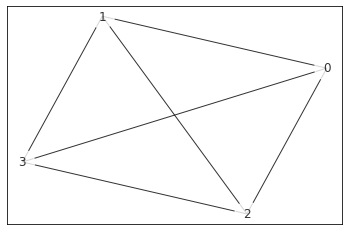

In [5]:
#some fancy graph
#G = nx.Graph([(0,1),(0,2),(0,3),(1,2),(1,3),(0,4),(2,4),(3,4),(2,5),(4,5),(1,6),(6,5)])

#nice testing graph
#G = nx.Graph([(0,1),(1,2),(1,3),(0,2),(2,4),(1,4)])

#Butterfly
#G = nx.Graph([(0,1),(1,2),(2,0),(0,3),(3,4),(4,0)]) 

#Star
#G = nx.Graph([(0,1),(0,2),(0,3)])


G = nx.Graph([(0,1),(1,2),(2,0),(3,2),(1,3),(3,0)])


#G = nx.Graph([(0,1)])
edges = len(G)
A = nx.adjacency_matrix(G)
A = np.array(A.todense())
# print(A)

#mc = maxcut(edges, [[0,1], [1,2], [1,3], [2,3]])
mc = maxcut(G)
mc.draw()
#print(10**(-7))

#mc.build_circuit([1],[1])
#mc.circuit.circ.draw()

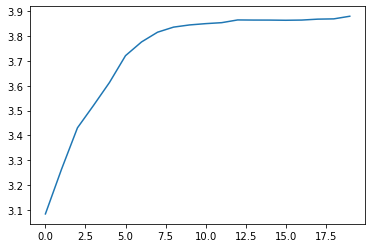

Wall time: 17.9 s


In [6]:
%%time

curve = mc.train(opt_rounds=20, depth = 3, sims = 10000, learning_rate = 0.01)
plt.plot(curve)
plt.show()

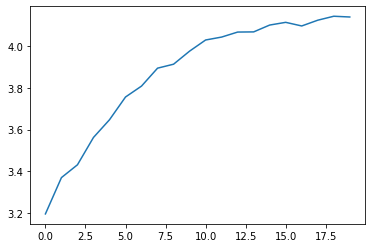

Wall time: 17.8 s


In [1129]:
%%time

curve = mc.train(opt_rounds=20, depth = 3, sims = 5000, learning_rate = 0.01)
plt.plot(curve)
plt.show()

In [1157]:
counts = mc.counts

sims=10000


newcounts = sorted(counts.items(), key = lambda x:(x[1], x[0]), reverse=True)
# print(newcounts)
# print(m)
# print(int(newcounts[0][m])*int(np.sum(np.outer(y,(1-y)) * A)))

# print(list(np.array(newcounts)[:,1].astype(int)))
# print(np.sum(list(np.array(newcounts)[:,1].astype(int))))
# print(np.sqrt(np.var(list(np.array(newcounts)[:,1].astype(int)))))

m = 0
amount = 0
exp_v = 0
var = np.sqrt(np.var(list(np.array(newcounts)[:,1].astype(int))))
while amount < 2*var:
    y = np.array([int(x) for x in list(newcounts[m][0].format(2**len(G)))])
    y = y[::-1]
    exp_v += int(newcounts[m][1])*int(np.sum(np.outer(y,(1-y)) * A))
    amount += int(newcounts[m][1])
    m += 1
print(amount)
print(exp_v/amount)
print(m)
# print(newcounts)

2707
3.0
1


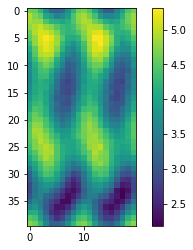

In [30]:
mc.heatmap(1, n_gamma=40, n_beta=20)

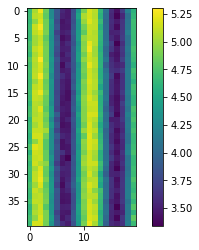

In [31]:
mc.heatmap(2, n_gamma=40, n_beta=20)

Optimal bitstring: [0 0 1 1]
Optimal value: 4
Total amount of difft solutions founds 16
trained beta: [0.5352  0.76545 0.52645]
trained gamma: [0.58305 0.6358  0.49225]


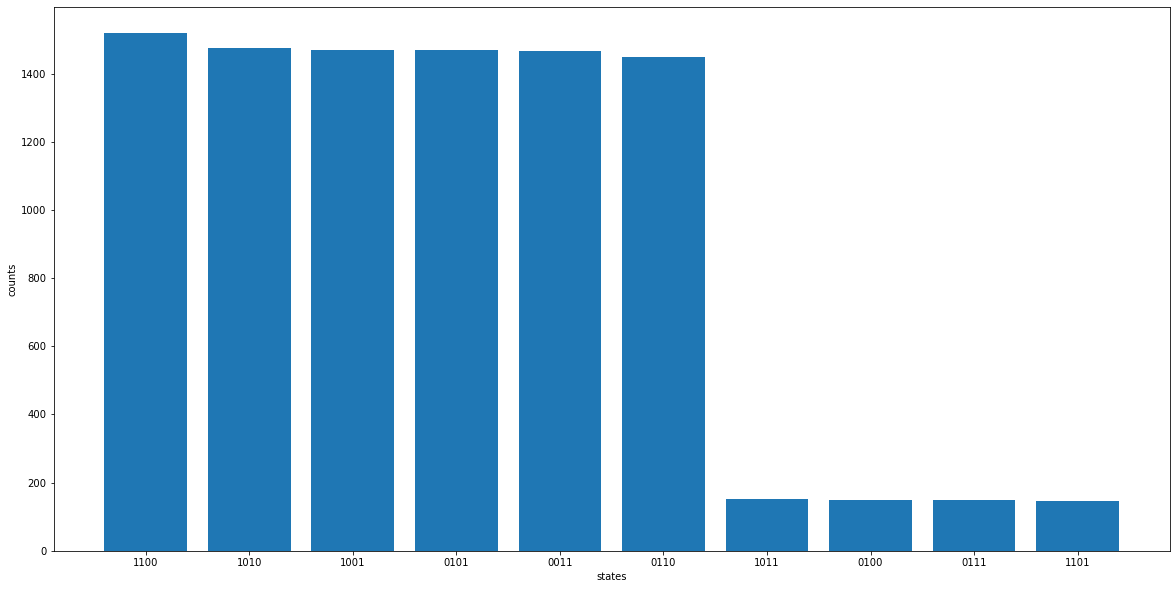

In [7]:
counts = mc.counts


y=0

newcounts = sorted(counts.items(), key = lambda x:(x[1], x[0]), reverse=True)


y = np.array([int(x) for x in list(newcounts[0][0].format(len(newcounts[0][0])))])
y = y[::-1]
print("Optimal bitstring:", y)
print("Optimal value:", int(np.sum(np.outer(y,(1-y)) * A)))
print("Total amount of difft solutions founds", len(counts))
print('trained beta:', mc.beta)
print('trained gamma:', mc.gamma)

bars = 10


plt.figure(figsize=(20,10))
plt.bar(range(min(len(counts),bars)), list(np.array(newcounts)[0:bars,1].astype(int)), align='center')
plt.xticks(range(min(len(counts),bars)), list(np.array(newcounts)[0:bars,0]))
plt.xlabel('states')
plt.ylabel('counts')
plt.show()


In [8]:
#Thingy for binary thingy
s = list("{0:0eb}")
s[4] = str(edges)
binlist="".join(s)

energy = np.zeros(2**edges, dtype=int)
for k in range(0,2**edges):
    y = np.array([int(x) for x in binlist.format(k)]) #btw we gotta change this part manually when we have larger graph
    energy[k] = int(np.sum(np.outer(y,(1-y)) * A))

energy.sort()
print(energy[::-1])

[4 4 4 4 4 4 3 3 3 3 3 3 3 3 0 0]
